In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from IPython.display import Markdown, display
from data_generator import vis_train_features, plot_raw_audio, plot_mfcc_feature
from IPython.display import Audio
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

# 1つのトレーニングデータからラベルと音声特徴量を抽出しています
vis_text, vis_raw_audio, vis_pncc_feature, vis_spectrogram_feature, vis_audio_path = vis_train_features()

# 生の音声データを確認する
plot_raw_audio(vis_raw_audio)
# play the audio file
Audio(vis_audio_path)

In [ ]:
from pncc import *
from librosa.core import load
plot_spectrogram_feature(power_to_db(pncc(vis_raw_audio)).T)

In [3]:
from librosa.core import load

In [4]:
environment_noise = load('./enviroment1.mp3', sr=16000)
environment_noise[0]

array([-5.9292738e-06,  1.0409491e-04,  1.9392908e-04, ...,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00], dtype=float32)

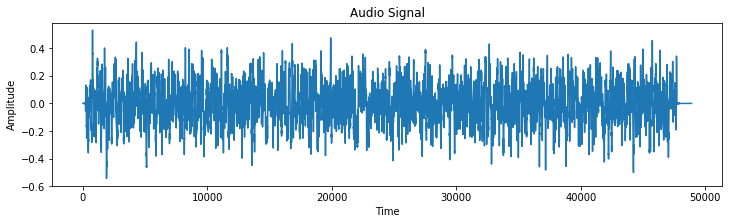

In [6]:
from data_generator import *
plot_raw_audio(environment_noise[0])

In [16]:
from pncc import *
pncc(environment_noise[0]).shape

(192, 13)

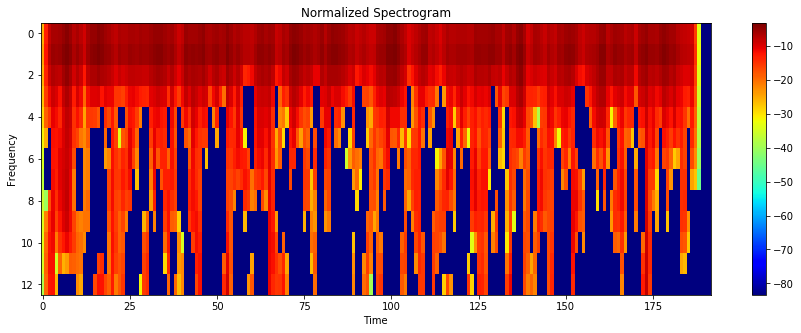

(13, 192)

In [19]:
plot_spectrogram_feature(power_to_db(pncc(environment_noise[0])).T)
power_to_db(pncc(environment_noise[0])).T.shape

In [7]:
new_wave = np.zeros(shape=(vis_raw_audio.shape[0]))
new_wave += vis_raw_audio

NameError: name 'vis_raw_audio' is not defined

In [8]:
for i in range(environment_noise[0].shape[0]):
    new_wave[i] += environment_noise[0][i] * 0.5
for i in range(environment_noise[0].shape[0]):
    new_wave[environment_noise[0].shape[0] + i] += environment_noise[0][i] * 0.5
for i in range(environment_noise[0].shape[0]):
    new_wave[int(environment_noise[0].shape[0] * 1.5) + i] += environment_noise[0][i] * 0.5

NameError: name 'new_wave' is not defined

In [ ]:
plot_raw_audio(vis_raw_audio)
plot_raw_audio(new_wave)

In [ ]:
max(environment_noise[0] )

In [ ]:
max(vis_raw_audio)

In [ ]:
from math import *
20 * log10(max(vis_raw_audio)/max(environment_noise[0] * 0.5))

In [ ]:
from data_generator import vis_train_features, plot_raw_audio, plot_mfcc_feature, plot_spectrogram_feature
from librosa.core import power_to_db, stft
from librosa.feature import melspectrogram, mfcc
from pncc import *

In [ ]:
plot_spectrogram_feature(power_to_db(melspectrogram(environment_noise[0], sr=16000,n_mels=40)))
plot_spectrogram_feature(power_to_db(melspectrogram(new_wave, sr=16000,n_mels=40)))
plot_spectrogram_feature(power_to_db(pncc(new_wave)).T)

## プリエンファシスフィルタ

In [ ]:
plot_raw_audio(new_wave)
pre_emphasis_signal= scipy.signal.lfilter([1.0, -0.97], 1, new_wave)
plot_raw_audio(pre_emphasis_signal)
plot_spectrogram_feature(power_to_db(melspectrogram(new_wave, sr=16000,n_mels=512)))
plot_spectrogram_feature(power_to_db(melspectrogram(pre_emphasis_signal, sr=16000,n_mels=40)))
power_to_db(melspectrogram(pre_emphasis_signal, sr=16000,n_mels=40)).shape

In [ ]:
n_fft=1024
n_mels=40
window="hamming"
stft_pre_emphasis_signal = np.abs(stft(pre_emphasis_signal,
                                            n_fft=n_fft, window=window)) ** 2
mel_filter = np.abs(filters.mel(16000, n_fft = n_fft, n_mels=n_mels)) ** 2
power_stft_pre_signal = np.dot(stft_pre_emphasis_signal.T, mel_filter.T)

In [ ]:
plot_spectrogram_feature(power_to_db(stft_pre_emphasis_signal))
plot_spectrogram_feature(power_to_db(power_stft_pre_signal).T)
power_to_db(power_stft_pre_signal).shape

In [ ]:
power_stft_pre_signal.shape

In [ ]:
def medium_time_power_calculation(p_, M=2):
    q_ = np.zeros(shape=(p_.shape[0], p_.shape[1]))
    p_ = np.pad(p_, [(M,M), (0, 0)], 'constant')
   
    for i in range(q_.shape[0]):
        for j in range(q_.shape[1]):
            q_[i, j] = sum([1/(2*M + 1) * p_[i + k - M, j] for k in range(5)])
    return q_

In [ ]:
q_ = medium_time_power_calculation(power_stft_pre_signal)
num = 0
print(power_stft_pre_signal.shape)
print(q_.shape)
plot_raw_audio(power_stft_pre_signal[:, num])
plot_raw_audio(q_[:, num])
plot_spectrogram_feature(power_to_db(power_stft_pre_signal.T))
plot_spectrogram_feature(power_to_db(q_.T))

In [ ]:
def asymmetric_lawpass_filtering(q_in, lm_a=0.999, lm_b=0.5):
    q_out = np.zeros(shape=(q_in.shape[0], q_in.shape[1]))
    q_out[0, :] = 0.9 * q_in[0, :]
    for l in range(q_out.shape[1]):
        for m in range(q_out.shape[0]):
            if (q_in[m, l] >= q_out[m-1, l]):
                q_out[m, l] = lm_a * q_out[m-1, l] + (1 - lm_a) * q_in[m, l]
            else:
                q_out[m, l] = lm_b * q_out[m-1, l] + (1 - lm_b) * q_in[m, l]
    return q_out

In [ ]:
q_le = asymmetric_lawpass_filtering(q_, 0.999, 0.5)
pre_q_0 = q_ - q_le

In [ ]:
plt.figure(figsize=(15, 5))

num = 20
#plt.plot(power_stft_pre_signal[:, num], label="power spectrum")
plt.plot(q_[:, num], label="medium-time power calculation")
plt.plot(q_le[:, num], label="q_le", c="b")
#plt.plot(pre_q_0[:, num], label="pre_q_o", c="g")
plt.legend()
plt.show()

In [ ]:
plot_spectrogram_feature(power_to_db(q_.T))
plot_spectrogram_feature(power_to_db(pre_q_0.T))

In [ ]:

%load_ext autoreload
%autoreload 2

In [ ]:
pre_q, q_ = pncc(new_wave)
plot_spectrogram_feature(power_to_db(melspectrogram(new_wave, sr=16000,n_mels=512)))
plot_spectrogram_feature(pre_q.T)
plot_spectrogram_feature(q_.T)
plot_spectrogram_feature(mfcc(vis_raw_audio, sr=16000, n_mfcc=13))
plot_spectrogram_feature(mfcc(new_wave, sr=16000, n_mfcc=13))

In [ ]:
melspectrogram(new_wave, sr=16000,n_mels=40)

In [ ]:
melspectrogram(environment_noise[0], n_mels=40).shape

In [ ]:
import numpy as np
new_wave = np.zeros(shape=(vis_raw_audio.shape[0]))

In [ ]:
new_wave += vis_raw_audio